### Import necessary libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
import time
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

### Reading the data files

In [4]:
melb_data = pd.read_csv('melb_data.csv')

### Inspecting the dataframes

In [13]:
pd.set_option('display.max_columns', None)  # Shows all columns

In [14]:
melb_data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,2.0,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,3.0,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [7]:
melb_data.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [8]:
len(melb_data)

34857

In [9]:
melb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  float64
 18  Longti

In [10]:
melb_data.nunique()

Suburb             351
Address          34009
Rooms               12
Type                 3
Price             2871
Method               9
SellerG            388
Date                78
Distance           215
Postcode           211
Bedroom2            15
Bathroom            11
Car                 15
Landsize          1684
BuildingArea       740
YearBuilt          160
CouncilArea         33
Lattitude        13402
Longtitude       14524
Regionname           8
Propertycount      342
dtype: int64

In [11]:
melb_data['Type'].unique()

array(['h', 'u', 't'], dtype=object)

### Data Cleaning

#### Checking for duplicate values

In [15]:
melb_data.duplicated().sum()

1

In [16]:
# Remove duplicate rows based on all columns
melb_data = melb_data.drop_duplicates()

#### One-hot encoding

In [17]:
# Perform one-hot encoding
melb_data = pd.get_dummies(melb_data, columns = ['Type'])
melb_data.head()

,Suburb,Address,Rooms,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Type_h,Type_t,Type_u
0,Abbotsford,68 Studley St,2,NaN,SS,Jellis,3/09/2016,2.5,3067.0,2.0,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0,True,False,False
1,Abbotsford,85 Turner St,2,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0,True,False,False
2,Abbotsford,25 Bloomburg St,2,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0,True,False,False
3,Abbotsford,18/659 Victoria St,3,NaN,VB,Rounds,4/02/2016,2.5,3067.0,3.0,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0,False,False,True
4,Abbotsford,5 Charles St,3,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0,True,False,False


#### Renaming the dataframe columns

In [18]:
# Renaming the dataframe columns
melb_data.rename(columns = {'Type_h': 'House', 
                     'Type_t': 'Townhouse', 
                     'Type_u': 'Duplex',
                    'Bedroom2': 'Bedrooms',
                    'Bathroom': 'Bathrooms',
                    'Car': 'ParkingCars',
                     'Lattitude': 'Latitude',
                    'Longtitude': 'Longitude',
                    'Propertycount': 'PropertyCount'}, inplace = True)

#### Dropping unnecessary columns

In [19]:
# Dropping unnecessary columns
melb_data.drop('Method', axis = 1, inplace = True)
melb_data.drop('SellerG', axis = 1, inplace = True)

#### Converting necessary columns to datetime

In [22]:
# Convert the 'Date' column to datetime
melb_data['Date'] = pd.to_datetime(melb_data['Date'], dayfirst=True)

#### Converting necessary columns to Int64

In [24]:
# Converting multiple columns to 'Int64' in one line
melb_data[['Postcode', 'Bedrooms', 'Bathrooms', 'ParkingCars', 'YearBuilt', 'PropertyCount']] = melb_data[['Postcode', 'Bedrooms', 'Bathrooms', 'ParkingCars', 'YearBuilt', 'PropertyCount']].astype('Int64')

#### Google Maps API Call & Function Creation

In [150]:
api_key = os.getenv('GOOGLE_API_KEY') 

if not api_key:
    raise ValueError("API key is not set in the environment variables")

In [151]:
def get_coordinates_from_address(address, api_key):
    # Setup retry strategy
    retry_strategy = Retry(
        total = 3,  # Retry a total of 3 times
        status_forcelist = [429, 500, 502, 503, 504],  # Status codes to retry for
        method_whitelist = ["HEAD", "GET", "OPTIONS"]  # Enabled methods to retry on
    )
    adapter = HTTPAdapter(max_retries = retry_strategy)
    http = requests.Session()
    http.mount("https://", adapter)
    http.mount("http://", adapter)

    url = f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={api_key}"
    try:
        response = http.get(url)
        if response.status_code != 200:
            return None, None

        results = response.json()
        if results.get('status') != 'OK':
            return None, None

        location = results['results'][0]['geometry']['location']
        return location['lat'], location['lng']
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None

In [152]:
def find_council(address, api_key):
    url = "https://maps.googleapis.com/maps/api/geocode/json"
    params = {'address': address, 'key': api_key}
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        if data['status'] == 'OK':
            # Find the council or local government area in the address components
            for component in data['results'][0]['address_components']:
                if 'administrative_area_level_2' in component['types']:
                    return component['long_name']
            return "Council not found"
        else:
            return "No results found"
    else:
        return "Failed to connect to the API"

#### Dealing with missing values in the dataset

In [25]:
melb_data = melb_data.dropna(subset = ['Price'])

In [26]:
na_distance = melb_data[melb_data['Distance'].isna()]
print(na_distance)

            Suburb       Address  Rooms     Price       Date  Distance  \
29483  Fawkner Lot  1/3 Brian St      3  616000.0 2018-01-06       NaN   

       Postcode  Bedrooms  Bathrooms  ParkingCars  Landsize  BuildingArea  \
29483      <NA>      <NA>       <NA>         <NA>       NaN           NaN   

       YearBuilt CouncilArea  Latitude  Longitude Regionname  PropertyCount  \
29483       <NA>         NaN       NaN        NaN        NaN           <NA>   

       House  Townhouse  Duplex  
29483   True      False   False  


In [154]:
address = '1/3 Brian St, Fawkner Lot'
coordinates = get_coordinates_from_address(address, api_key)
print("Coordinates:", coordinates)

/var/folders/yw/4jpdvg_930bf7v2860107yfw0000gn/T/ipykernel_8333/3520423890.py:3: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


Coordinates: (-37.6949888, 144.9676573)


In [27]:
melb_data[melb_data['Suburb'] == 'Fawkner Lot']

,Suburb,Address,Rooms,Price,Date,Distance,Postcode,Bedrooms,Bathrooms,ParkingCars,Landsize,BuildingArea,YearBuilt,CouncilArea,Latitude,Longitude,Regionname,PropertyCount,House,Townhouse,Duplex
29483,Fawkner Lot,1/3 Brian St,3,616000.0,2018-01-06,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>,True,False,False


In [28]:
melb_data.loc[melb_data['Suburb'] == 'Fawkner Lot', 'Latitude'] = -37.6949888
melb_data.loc[melb_data['Suburb'] == 'Fawkner Lot', 'Longitude'] = 144.9676573

In [29]:
# Fawkner's postcode is 3060
melb_data.loc[melb_data['Suburb'] == 'Fawkner Lot', 'Postcode'] = 3060

In [ ]:
address = '1/3 Brian St, Fawkner Lot'
council = find_council(address, api_key)
print("Council:", council)

In [159]:
melb_data.loc[melb_data['Suburb'] == 'Fawkner Lot', 'CouncilArea'] = 'City of Merri-bek'

In [160]:
melb_data.loc[melb_data['Suburb'] == 'Fawkner Lot', 'Regionname'] = 'Northern Metropolitan'

In [31]:
melb_data[melb_data['CouncilArea'].isna()]

,Suburb,Address,Rooms,Price,Date,Distance,Postcode,Bedrooms,Bathrooms,ParkingCars,Landsize,BuildingArea,YearBuilt,CouncilArea,Latitude,Longitude,Regionname,PropertyCount,House,Townhouse,Duplex
18523,Footscray,2/16 Stafford St,2,710000.0,2017-07-15,5.1,3011,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>,False,False,True
26888,Camberwell,2/3 Kingsley St,2,825000.0,2017-11-11,7.7,3124,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>,True,False,False
29483,Fawkner Lot,1/3 Brian St,3,616000.0,2018-01-06,NaN,3060,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN,-37.694989,144.967657,NaN,<NA>,True,False,False


In [162]:
melb_data[melb_data['Suburb'] == 'Footscray']

,Suburb,Address,Rooms,Price,Date,Distance,Postcode,Bedrooms,Bathrooms,ParkingCars,Landsize,BuildingArea,YearBuilt,CouncilArea,Latitude,Longitude,Regionname,PropertyCount,House,Townhouse,Duplex
4377,Footscray,4/33 Ballarat Rd,3,585000.000,2016-03-09,6.400,3011,3,1,1,259.000,NaN,<NA>,Maribyrnong City Council,-37.795,144.906,Western Metropolitan,7570,0,1,0
4378,Footscray,202/51 Gordon St,1,85000.000,2016-03-09,6.400,3011,1,1,0,0.000,NaN,2007,Maribyrnong City Council,-37.791,144.890,Western Metropolitan,7570,0,0,1
4379,Footscray,4 Adelaide St,4,1225000.000,2016-03-12,6.400,3011,4,2,1,319.000,130.000,1915,Maribyrnong City Council,-37.794,144.887,Western Metropolitan,7570,1,0,0
4380,Footscray,11/44 Everard St,2,431000.000,2016-03-12,6.400,3011,2,1,1,0.000,NaN,<NA>,Maribyrnong City Council,-37.796,144.885,Western Metropolitan,7570,0,0,1
4381,Footscray,9 Lynch St,3,1003000.000,2016-03-12,6.400,3011,3,1,1,292.000,98.000,1900,Maribyrnong City Council,-37.797,144.905,Western Metropolitan,7570,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34253,Footscray,105 Eleanor St,3,945000.000,2018-02-24,5.100,3011,3,1,0,219.000,107.000,1900,Maribyrnong City Council,-37.797,144.885,Western Metropolitan,7570,1,0,0
34254,Footscray,4/5 Gordon St,2,375500.000,2018-02-24,5.100,3011,<NA>,<NA>,<NA>,NaN,NaN,<NA>,Maribyrnong City Council,NaN,NaN,Western Metropolitan,7570,0,0,1
34255,Footscray,11/49 Hyde St,2,450000.000,2018-02-24,5.100,3011,<NA>,<NA>,<NA>,NaN,NaN,<NA>,Maribyrnong City Council,NaN,NaN,Western Metropolitan,7570,0,0,1
34256,Footscray,2/1 Leander St,2,660000.000,2018-02-24,5.100,3011,<NA>,<NA>,<NA>,NaN,NaN,<NA>,Maribyrnong City Council,NaN,NaN,Western Metropolitan,7570,0,1,0


In [163]:
# Replace the 'NA' at index 18523
melb_data.loc[18523, 'CouncilArea'] = 'Maribyrnong City Council'
melb_data.loc[18523, 'Regionname'] = 'Western Metropolitan'
melb_data.loc[18523, 'PropertyCount'] = 7570

In [164]:
melb_data[melb_data['Suburb'] == 'Camberwell']

,Suburb,Address,Rooms,Price,Date,Distance,Postcode,Bedrooms,Bathrooms,ParkingCars,Landsize,BuildingArea,YearBuilt,CouncilArea,Latitude,Longitude,Regionname,PropertyCount,House,Townhouse,Duplex
2618,Camberwell,28 Brinsley Rd,4,2650000.000,2016-03-09,7.800,3124,4,2,1,652.000,189.000,1890,Boroondara City Council,-37.829,145.069,Southern Metropolitan,8920,1,0,0
2619,Camberwell,2/1 Glen Iris Rd,3,1615000.000,2016-03-09,7.800,3124,3,1,2,389.000,NaN,<NA>,Boroondara City Council,-37.843,145.070,Southern Metropolitan,8920,0,1,0
2620,Camberwell,6 Kalang Rd,3,NaN,2016-03-09,7.800,3124,3,1,1,980.000,154.000,1930,Boroondara City Council,-37.844,145.077,Southern Metropolitan,8920,1,0,0
2621,Camberwell,1288 Toorak Rd,4,3225000.000,2016-03-09,7.800,3124,4,3,2,934.000,NaN,<NA>,Boroondara City Council,-37.850,145.087,Southern Metropolitan,8920,1,0,0
2622,Camberwell,1/19 Alma Rd,3,NaN,2016-03-12,7.800,3124,3,2,2,332.000,NaN,1995,Boroondara City Council,-37.837,145.059,Southern Metropolitan,8920,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34080,Camberwell,29 Oxford St,3,1888000.000,2018-02-24,7.700,3124,3,1,2,770.000,NaN,<NA>,Boroondara City Council,-37.845,145.093,Southern Metropolitan,8920,1,0,0
34081,Camberwell,23 Radnor St,3,NaN,2018-02-24,7.700,3124,3,2,2,597.000,176.000,1915,Boroondara City Council,-37.841,145.062,Southern Metropolitan,8920,1,0,0
34082,Camberwell,674 Riversdale Rd,3,NaN,2018-02-24,7.700,3124,3,1,2,675.000,155.000,1940,Boroondara City Council,-37.833,145.072,Southern Metropolitan,8920,1,0,0
34083,Camberwell,1088 Toorak Rd,3,NaN,2018-02-24,7.700,3124,3,1,1,647.000,0.000,<NA>,Boroondara City Council,-37.848,145.074,Southern Metropolitan,8920,1,0,0


In [165]:
# Replace the 'NA' at index 26888
melb_data.loc[26888, 'CouncilArea'] = 'Boroondara City Council'
melb_data.loc[26888, 'Regionname'] = 'Southern Metropolitan'
melb_data.loc[26888, 'PropertyCount'] = 8920

In [166]:
def fill_coordinates(row):
    if pd.isna(row['Latitude']) or pd.isna(row['Longitude']):
        full_address = f"{row['Address'].strip()}, {row['Suburb'].strip()}"  # Combine address and suburb
        lat, lng = get_coordinates_from_address(full_address, api_key)
        time.sleep(1)  # Sleep for 1 second to respect rate limits
        if lat is not None and lng is not None:
            return pd.Series([lat, lng])
    return pd.Series([row['Latitude'], row['Longitude']])

In [40]:
# Apply the function
melb_data[['Latitude', 'Longitude']] = melb_data.apply(fill_coordinates, axis = 1)

/var/folders/yw/4jpdvg_930bf7v2860107yfw0000gn/T/ipykernel_1212/3520423890.py:3: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


           Suburb             Address  Rooms      Price       Date  Distance  \
0      Abbotsford       68 Studley St      2        NaN 2016-03-09       2.5   
1      Abbotsford        85 Turner St      2  1480000.0 2016-03-12       2.5   
2      Abbotsford     25 Bloomburg St      2  1035000.0 2016-04-02       2.5   
3      Abbotsford  18/659 Victoria St      3        NaN 2016-04-02       2.5   
4      Abbotsford        5 Charles St      3  1465000.0 2017-04-03       2.5   
...           ...                 ...    ...        ...        ...       ...   
34852  Yarraville         13 Burns St      4  1480000.0 2018-02-24       6.3   
34853  Yarraville       29A Murray St      2   888000.0 2018-02-24       6.3   
34854  Yarraville      147A Severn St      2   705000.0 2018-02-24       6.3   
34855  Yarraville    12/37 Stephen St      3  1140000.0 2018-02-24       6.3   
34856  Yarraville    3 Tarrengower St      2  1020000.0 2018-02-24       6.3   

       Postcode  Bedrooms  Bathrooms  P

In [41]:
melb_data.isna().sum()

Suburb               0
Address              0
Rooms                0
Price             7610
Date                 0
Distance             1
Postcode             0
Bedrooms          8217
Bathrooms         8226
ParkingCars       8728
Landsize         11810
BuildingArea     21115
YearBuilt        19306
CouncilArea          0
Latitude            44
Longitude           44
Regionname           0
PropertyCount        1
House                0
Townhouse            0
Duplex               0
dtype: int64

### Outlier Detection

In [32]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [33]:
## remove the line after finishing the project
df = pd.read_csv('cleaned_dataset.csv')

In [34]:
##remove later on
df = df.dropna(subset = ['Price'])

In [35]:
df.describe()

,Unnamed: 0,Rooms,Price,Postcode,Bedrooms,Bathrooms,ParkingCars,Landsize,BuildingArea,YearBuilt,Latitude,Longitude,PropertyCount,House,Townhouse,Duplex,DistanceToCBD
count,27247.000,27247.000,27247.000,27247.000,20806.000,20800.000,20423.000,17982.000,10656.000,12084.000,27210.000,27210.000,27246.000,27247.000,27247.000,27247.000,27210.000
mean,17460.472,2.992,1050173.345,3113.794,3.046,1.592,1.715,593.489,156.835,1966.609,-37.590,144.453,7566.831,0.678,0.105,0.217,80.998
std,10033.858,0.955,641467.130,111.138,0.955,0.701,0.994,3757.266,449.223,36.762,4.161,10.760,4492.225,0.467,0.307,0.412,1281.735
min,1.000,1.000,85000.000,3000.000,0.000,0.000,0.000,0.000,0.000,1196.000,-38.190,-122.402,83.000,0.000,0.000,0.000,0.098
25%,8802.500,2.000,635000.000,3046.000,2.000,1.000,1.000,219.000,100.000,1950.000,-37.861,144.926,4294.000,0.000,0.000,0.000,8.325
50%,17528.000,3.000,870000.000,3088.000,3.000,1.000,2.000,512.000,133.000,1970.000,-37.801,145.005,6567.000,1.000,0.000,0.000,12.742
75%,26085.000,4.000,1295000.000,3153.000,4.000,2.000,2.000,664.000,182.000,2000.000,-37.748,145.069,10412.000,1.000,0.000,0.000,17.845
max,34856.000,16.000,11200000.000,3978.000,20.000,9.000,18.000,433014.000,44515.000,2019.000,53.763,174.924,21650.000,1.000,1.000,1.000,30895.004


In [36]:
df['Bedrooms'].unique()

array([ 2.,  3.,  4., nan,  1.,  6.,  5.,  0.,  8.,  9.,  7., 20., 10.,
       16., 12.])

In [37]:
# Replace 0 values in 'Bedrooms' with NaN
df['Bedrooms'].replace(0, np.nan, inplace = True)

/var/folders/yw/4jpdvg_930bf7v2860107yfw0000gn/T/ipykernel_30461/1597874070.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Bedrooms'].replace(0, np.nan, inplace = True)


In [42]:
# Calculate median bedrooms for each suburb
median_bedrooms = df[df['Bedrooms'] > 0].groupby('Suburb')['Bedrooms'].median()

# Function to replace 0 bedrooms with the suburb median
def replace_zero_bedrooms(row):
    if row['Bedrooms'] == 0:
        return median_bedrooms.get(row['Suburb'], 0)
    else:
        return row['Bedrooms']

# Apply the function
df['Bedrooms'] = df.apply(replace_zero_bedrooms, axis = 1)

In [43]:
df['Bathrooms'].unique()

array([ 1.,  2., nan,  3.,  4.,  7.,  5.,  6.,  8.,  9.])

In [44]:
# Replace 0 values in 'Bathrooms' with NaN
df['Bathrooms'].replace(0, np.nan, inplace = True)

/var/folders/yw/4jpdvg_930bf7v2860107yfw0000gn/T/ipykernel_30461/3363281290.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Bathrooms'].replace(0, np.nan, inplace = True)


In [45]:
# Calculate median bathrooms for each suburb
median_bathrooms = df[df['Bathrooms'] > 0].groupby('Suburb')['Bathrooms'].median()

# Function to replace 0 bathrooms with the suburb median
def replace_zero_bathrooms(row):
    if row['Bathrooms'] == 0:
        return median_bathrooms.get(row['Suburb'], 0)
    else:
        return row['Bathrooms']

# Apply the function
df['Bathrooms'] = df.apply(replace_zero_bathrooms, axis = 1)

In [46]:
(df['Landsize'] == 0).sum()

1942

In [47]:
df['Landsize'] = df['Landsize'].replace(0, np.nan)

In [48]:
(df['BuildingArea'] == 0). sum()

61

In [49]:
# Drop rows where the values in 'BuildingArea' are 0
df = df[df['BuildingArea'] != 0]

In [50]:
df['YearBuilt'].max()

2019.0

In [51]:
(df['YearBuilt'] > 2024).sum()

0

In [52]:
df = df[df['YearBuilt'] <= 2106]

In [53]:
df.isna().sum()

Unnamed: 0          0
Suburb              0
Address             0
Rooms               0
Price               0
Date                0
Postcode            0
Bedrooms            5
Bathrooms           3
ParkingCars       194
Landsize         2739
BuildingArea     1835
YearBuilt           0
CouncilArea         0
Latitude            0
Longitude           0
Regionname          0
PropertyCount       0
House               0
Townhouse           0
Duplex              0
DistanceToCBD       0
dtype: int64

### Exploratory Data Analysis

Categorical Variables:
- Suburb
- Address
- Date
- CouncilArea
- Regionname
- House
- Townhouse
- Duplex

Numerical Variables:
- Rooms
- Price
- DistanceToCBD
- Postcode
- Bedrooms
- Bathrooms
- ParkingCars
- Landsize
- BuildingArea
- YearBuilt
- Lattitude
- Longtitude
- Propertycount

#### Categorical Variable

In [54]:
def bar_plot(variable):

    var = df[variable]
    
    varValue = var.value_counts()
    
    # visualize
    plt.figure(figsize =(9,3))
    plt.bar(varValue.index, varValue)
    plt.xticks(varValue.index, varValue.index.values, rotation = 90)
    plt.title(variable)
    plt.show()
    print("{}: \n {}".format(variable, varValue))

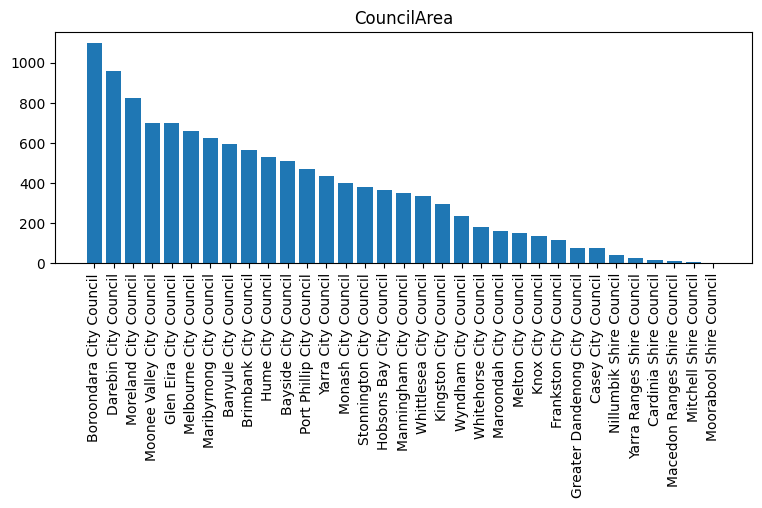

CouncilArea: 
 CouncilArea
Boroondara City Council           1098
Darebin City Council               961
Moreland City Council              826
Moonee Valley City Council         699
Glen Eira City Council             699
Melbourne City Council             662
Maribyrnong City Council           627
Banyule City Council               596
Brimbank City Council              565
Hume City Council                  528
Bayside City Council               508
Port Phillip City Council          470
Yarra City Council                 435
Monash City Council                398
Stonnington City Council           382
Hobsons Bay City Council           364
Manningham City Council            348
Whittlesea City Council            337
Kingston City Council              296
Wyndham City Council               234
Whitehorse City Council            178
Maroondah City Council             161
Melton City Council                149
Knox City Council                  134
Frankston City Council             11

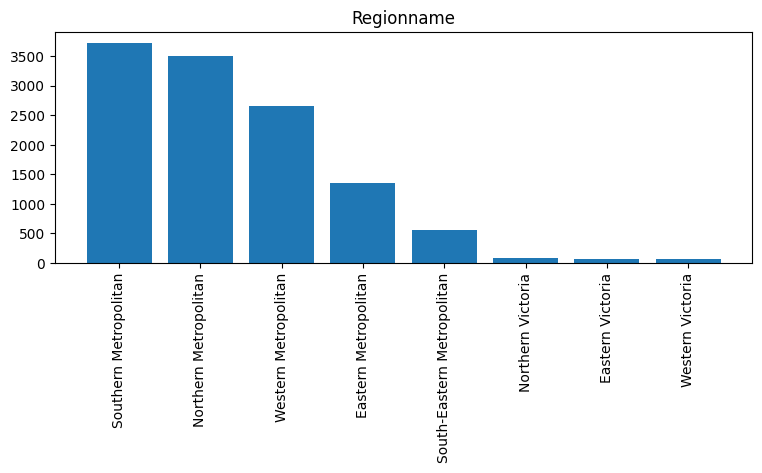

Regionname: 
 Regionname
Southern Metropolitan         3720
Northern Metropolitan         3498
Western Metropolitan          2663
Eastern Metropolitan          1361
South-Eastern Metropolitan     554
Northern Victoria               90
Eastern Victoria                75
Western Victoria                63
Name: count, dtype: int64


In [55]:
categories1 = ['CouncilArea', 'Regionname']

for c in categories1:
    bar_plot(c)

#### Numerical Variable

In [56]:
def plot_hist(variable):
    plt.figure(figsize = (9,3))
    plt.hist(df[variable], bins = 25)
    plt.xlabel(variable)
    plt.title("{} disribution with hist".format(variable))
    plt.show()

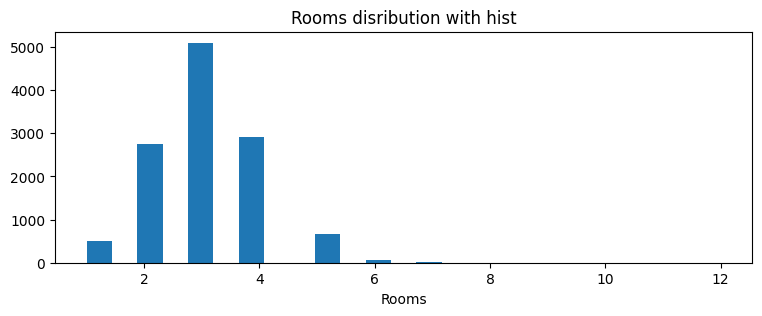

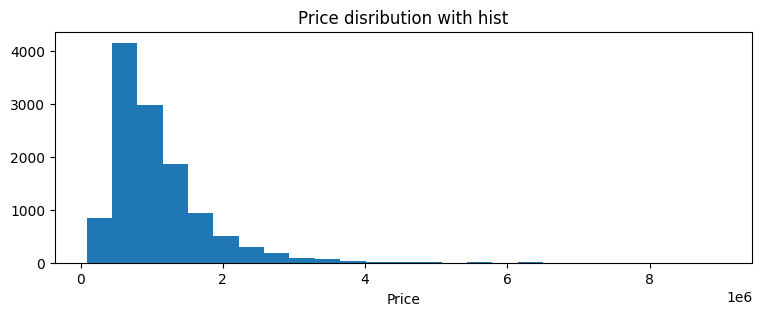

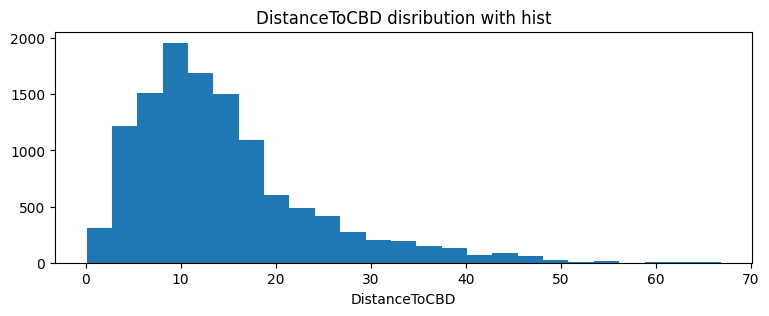

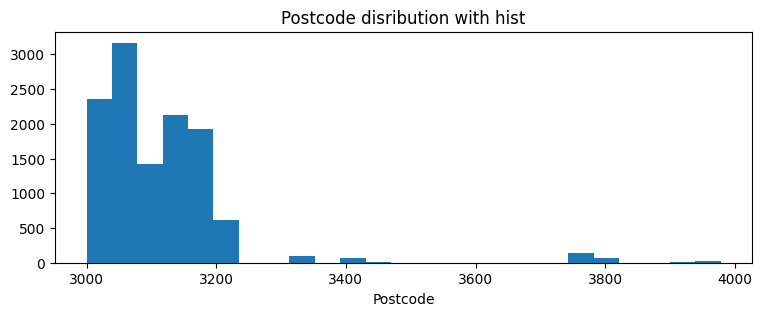

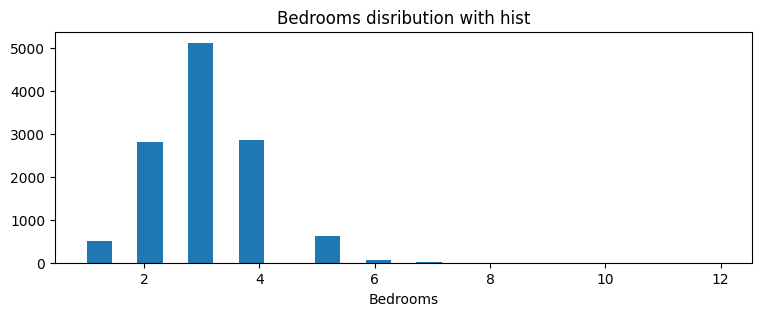

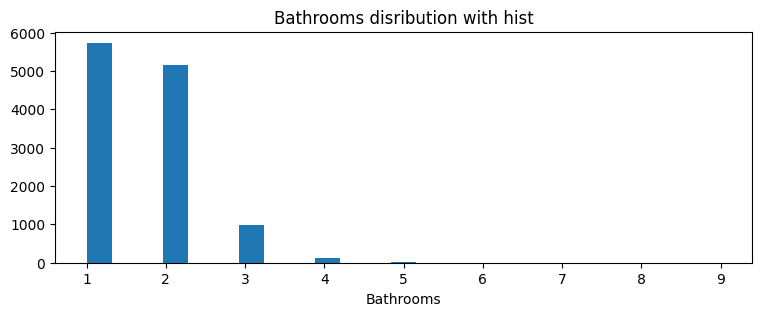

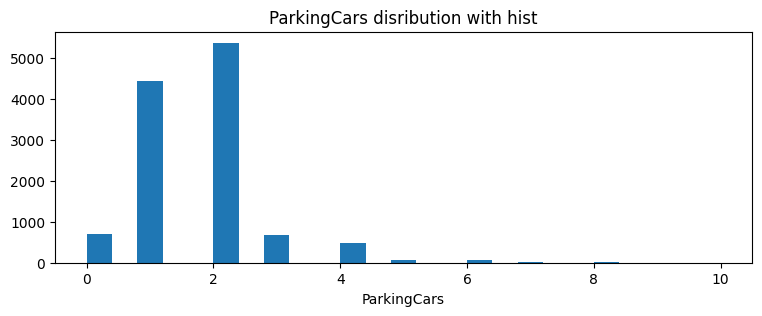

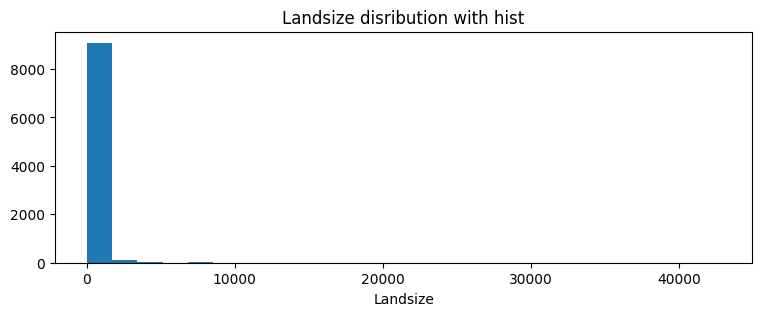

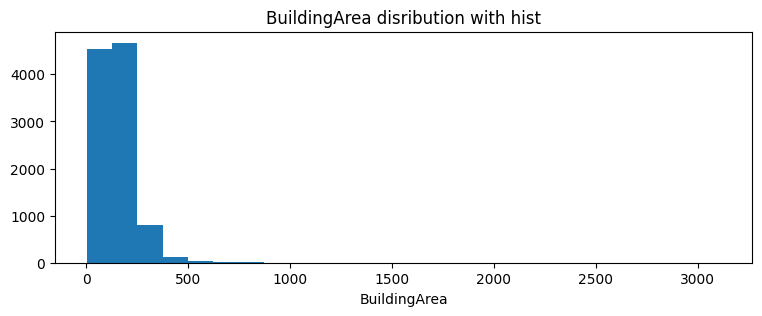

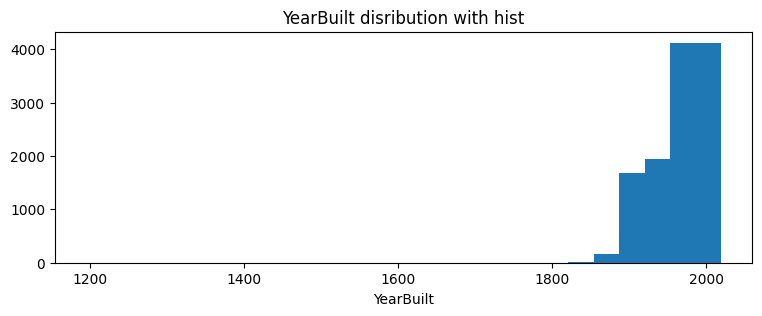

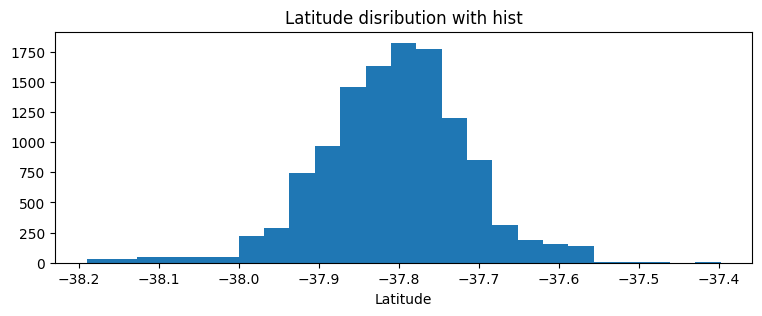

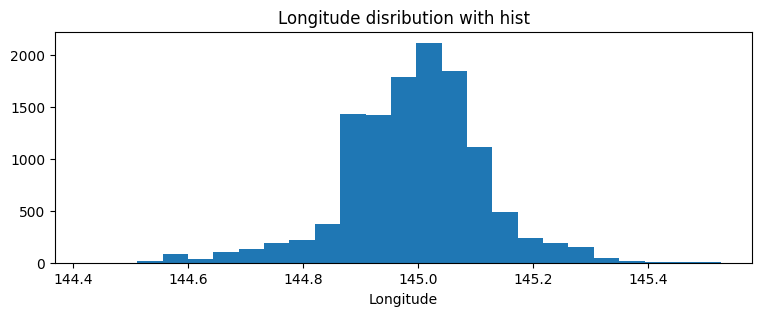

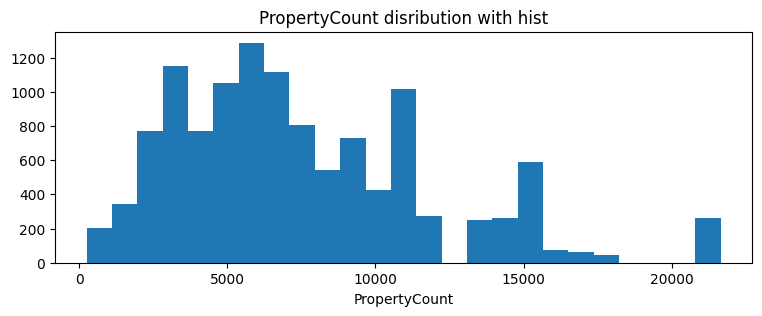

In [57]:
numericVar = ['Rooms','Price','DistanceToCBD','Postcode','Bedrooms','Bathrooms','ParkingCars','Landsize','BuildingArea','YearBuilt','Latitude', 'Longitude','PropertyCount']

for n in numericVar:
    plot_hist(n)

#### Analysis Between Some Features

- Rooms - Price
- Bedrooms - Price
- Bathrooms - Price
- BuildingArea - Price
- ParkingCars - Price
- House - Price
- Townhouse - Price
- Duplex - Price

In [58]:
# Rooms - Price
df[["Rooms", "Price"]].groupby(["Rooms"], as_index = False).mean().sort_values(by = "Price", ascending = False)

,Rooms,Price
5,6,2036000.000
6,7,1974272.727
4,5,1897435.148
8,10,1607500.000
7,8,1401753.200
3,4,1372894.311
2,3,1032482.935
1,2,744764.204
9,12,710000.000
0,1,416750.403


In [26]:
# Bedrooms - Price
df[["Bedrooms", "Price"]].groupby(["Bedrooms"], as_index = False).mean().sort_values(by = "Price", ascending = False)

,Bedrooms,Price
5,6.000,2019548.387
6,7.000,1979666.667
4,5.000,1874726.556
9,10.000,1607500.000
8,9.000,1487000.000
3,4.000,1380280.193
7,8.000,1059255.333
2,3.000,1037897.137
1,2.000,753487.765
10,12.000,710000.000


In [59]:
# Bathrooms - Price
df[["Bathrooms", "Price"]].groupby(["Bathrooms"], as_index = False).mean().sort_values(by = "Price", ascending = False)

,Bathrooms,Price
5,6.000,3490250.000
6,7.000,2950000.000
3,4.000,2705718.644
4,5.000,2655290.323
8,9.000,2315000.000
2,3.000,1752156.792
1,2.000,1175988.220
0,1.000,828726.709
7,8.000,760000.000


In [28]:
# BuildingArea - Price
df[["BuildingArea", "Price"]].groupby(["BuildingArea"], as_index = False).mean().sort_values(by = "Price", ascending = False)

,BuildingArea,Price
548,464.300,8000000.000
588,638.000,5770000.000
517,414.000,5580000.000
566,516.000,5525000.000
565,513.000,5150000.000
...,...,...
23,33.000,312400.000
67,66.320,300000.000
178,122.860,295000.000
35,42.200,286000.000


In [60]:
# ParkingCars - Price
df[["ParkingCars", "Price"]].groupby(["ParkingCars"], as_index = False).mean().sort_values(by = "Price", ascending = False)

,ParkingCars,Price
9,9.000,2100000.000
7,7.000,1901111.111
8,8.000,1489000.000
5,5.000,1428933.333
4,4.000,1374943.700
3,3.000,1360145.480
6,6.000,1252353.846
2,2.000,1191134.760
0,0.000,1088644.071
10,10.000,939000.000


In [61]:
# House - Price
df[["House", "Price"]].groupby(["House"], as_index = False).mean().sort_values(by = "Price", ascending = False)

,House,Price
1,1,1224443.048
0,0,693772.909


In [62]:
# Townhouse - Price
df[["Townhouse", "Price"]].groupby(["Townhouse"], as_index = False).mean().sort_values(by = "Price", ascending = False)

,Townhouse,Price
0,0,1092269.050
1,1,916657.566


In [63]:
# Duplex - Price
df[["Duplex", "Price"]].groupby(["Duplex"], as_index = False).mean().sort_values(by = "Price", ascending = False)

,Duplex,Price
0,0,1191792.895
1,1,594079.164


#### Visualisation

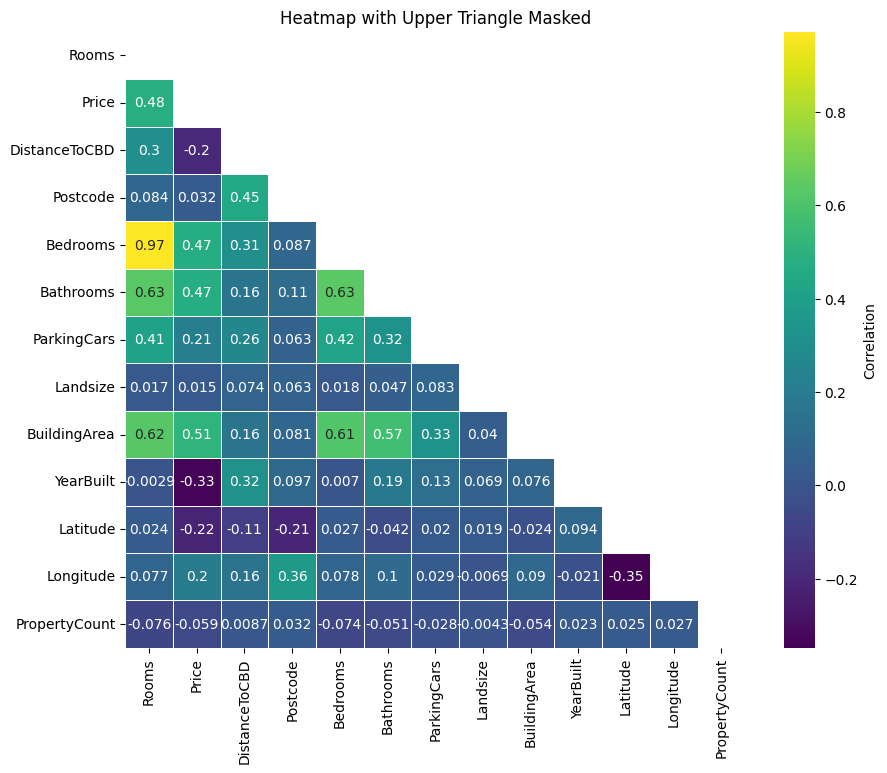

In [64]:
corr = df[numericVar].corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

plt.figure(figsize = (10, 8))
sns.heatmap(corr, mask = mask, annot = True, cmap = 'viridis', cbar_kws = {'label': 'Correlation'}, linewidths = 0.5)
plt.title('Heatmap with Upper Triangle Masked')
plt.show()

### Baseline Model

In [65]:
df = pd.get_dummies(df, drop_first = True)

In [66]:
X = df.drop('Price', axis = 1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [67]:
model = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = 100, learning_rate = 0.1, max_depth = 3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 83561139695.2988
